# Training an SNN with fewer SynOps and monitoring the firing rate
In the previous tutorial we saw how we can train an ANN with a low number of synaptic operations (SynOps). The same can be done when training an SNN directly. For good measure we will also monitor the neuron firing rates to make sure that they are in a reasonable range. Let's start by defining a spiking model. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import sinabs
import sinabs.layers as sl

# Seed for reproducibility
torch.manual_seed(1)

class SNN(nn.Sequential):
    def __init__(self, batch_size):
        super().__init__(
            sl.FlattenTime(),
            nn.Conv2d(1, 16, 5, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            sl.SumPool2d(2),
            nn.Conv2d(16, 32, 5, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            sl.SumPool2d(2),
            nn.Conv2d(32, 120, 4, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            nn.Flatten(),
            nn.Linear(120, 10, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            sl.UnflattenTime(batch_size=batch_size),
        )

batch_size = 5
snn = SNN(batch_size=batch_size)

Let's make our SNN track how many synaptic operations it generates during a single sample. We can use the same function as in the previous tutorial to set up the corresponding hooks. Apart from that, let's add another hook to monitor neuron firing rates. Sinabs provides two options for this: `firing_rate_hook` and `firing_rate_per_neuron_hook`. The former will give you a single value per layer: The average firing rate over time (and batches) across all neurons. The other one stores a tensor of the same shape as your spiking layer. It will give a mean firing rate for each neuron individually. In both cases, the rates are in units of *spikes per timestep*. For now we will use the `firing_rate_per_neuron_hook`.

In [2]:
from sinabs.hooks import register_synops_hooks, firing_rate_per_neuron_hook

# Register the synops hooks with our SNN
register_synops_hooks(snn)

# Register firing rate hooks to the spiking layers
for layer in snn:
    if isinstance(layer, sl.StatefulLayer) and layer.does_spike:
        layer.register_forward_hook(firing_rate_per_neuron_hook)

# Forward pass to record the number of synaptic operations
rand_input_spikes = (torch.ones((batch_size, 10, 1, 28, 28)) ).float()
snn(rand_input_spikes)

print("Synops after feeding input:")
print(f"Total: {snn.hook_data['total_synops_per_timestep']:.2e} SynOps per step")

Synops after feeding input:
Total: 1.22e+06 SynOps per step


You can also break down the statistics for each convolutional or linear layer.

In [3]:
print("Per layer:")
for layer_idx, synops in snn.hook_data['synops_per_timestep'].items():
    print(f"- Layer {layer_idx}: {synops:.2e} SynOps per step")

Per layer:
- Layer 1: 2.30e+05 SynOps per step
- Layer 4: 9.01e+05 SynOps per step
- Layer 7: 8.83e+04 SynOps per step
- Layer 10: 7.31e+02 SynOps per step


Let's also take a look at how the firing rates are distributed for the spiking layers:

In [4]:
import seaborn as sns

Layer 2:
	Shape: torch.Size([16, 24, 24])
	Silent neurons: 50.00%
Layer 5:
	Shape: torch.Size([32, 8, 8])
	Silent neurons: 50.00%
Layer 8:
	Shape: torch.Size([120, 1, 1])
	Silent neurons: 46.67%
Layer 11:
	Shape: torch.Size([10])
	Silent neurons: 30.00%


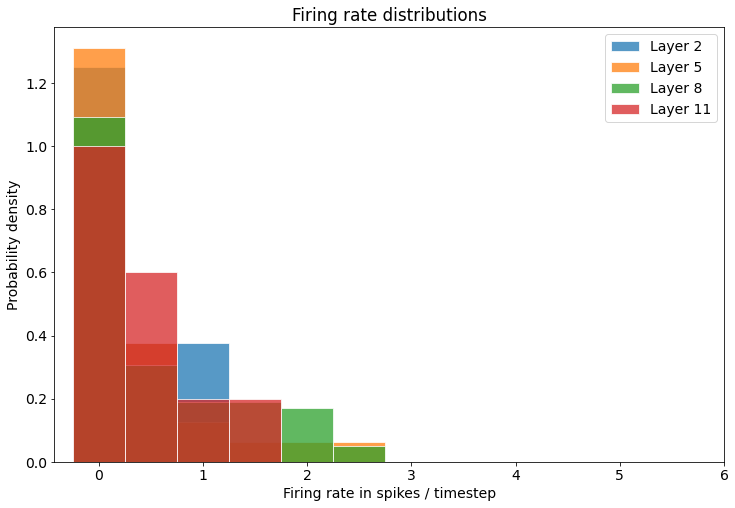

In [5]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 14
bins = (np.arange(8) - 0.5) * 0.5
for layer_idx, layer in enumerate(snn):
    if isinstance(layer, sl.StatefulLayer) and hasattr(layer, "hook_data"):
        firing_rates = layer.hook_data["firing_rate_per_neuron"]
        print(f"Layer {layer_idx}:")
        print(f"\tShape: {firing_rates.shape}")
        print(f"\tSilent neurons: {(firing_rates == 0).float().mean():.2%}")
        plt.hist(
            firing_rates.detach().numpy().flat,
            bins=bins,
            label=f"Layer {layer_idx}",
            density=True,
            ec="white",
            alpha=0.75,
        )
plt.xticks(np.arange(7))
plt.xlabel("Firing rate in spikes / timestep")
plt.ylabel("Probability density")
plt.legend(loc="best")
plt.title("Firing rate distributions");

Once we can calculate the total number of synaptic operations, we might want to choose a target SynOps number as part of our objective function. This time, let's optimize each layer individually, rather than their sum. We will set a target of 500'000 operations per layer.

Furthermore, looking at the firing rate distributions, we see that many neurons fire very sparsely or not at all. While sparsity is great in terms of energy efficiency, neurons that fire too rarely will not transmit sufficient information. Let's add a regularizer that punishes low firing rates to ensure that there is enough spiking activity in the network. We will set a target rate of at least 0.5 spikes per step for now.

In [6]:
# Helper functions to calculate the SynOp loss for each layer

def get_synops_squared_error(synops, target_synops):
    """ SynOps loss term for individual layer:
    Squared error on anything above the target
    """
    # Use ReLU so that only values above taret are punished
    above_target = nn.functional.relu(synops - target_synops)
    # Return squared error
    return above_target**2
    
def get_synops_loss(snn, target_synops):
    """ Sum of synop losses of individual layers"""
    loss = sum(
        get_synops_squared_error(synops, target_synops)
        for synops in snn.hook_data["synops_per_timestep"].values()
    )
    return loss

def get_firing_rate_squared_error(firing_rates, target_rate):
    """ Firing rate loss term for individual layer:
    Squared error on anything below the target
    """
    # Use ReLU so that only values below target are punished
    below_target = nn.functional.relu(target_rate - firing_rates)
    # Return sum of squared errors
    return (below_target**2).sum()

def get_firing_rate_loss(snn, target_rate):
    """ Sum of firing rate losses of individual layers"""
    loss = sum(
        get_firing_rate_squared_error(layer.hook_data["firing_rate_per_neuron"], target_rate)
        for layer in snn 
        if hasattr(layer, "hook_data") and "firing_rate_per_neuron" in layer.hook_data
    )
    return loss

In [7]:
# Choose the target number of operations
target_synops = 1e5
target_firing_rate = 0.5
synops_loss_weight = 0.01
rate_loss_weight = 1.

optim = torch.optim.Adam(snn.parameters(), lr=1e-3)

synops_per_layer = {idx: [] for idx in (1, 4, 7, 10)}
for epoch in range(100):
    sinabs.reset_states(snn)
    sinabs.zero_grad(snn)
    optim.zero_grad()
    
    snn(rand_input_spikes)
    
    synop_loss = synops_loss_weight * get_synops_loss(snn, target_synops)
    firing_rate_loss = rate_loss_weight * get_firing_rate_loss(snn, target_firing_rate)
    loss = synop_loss + firing_rate_loss
    loss.backward()
    optim.step()
    for idx, synops in snn.hook_data["synops_per_timestep"].items():
        synops_per_layer[idx].append(synops.item())

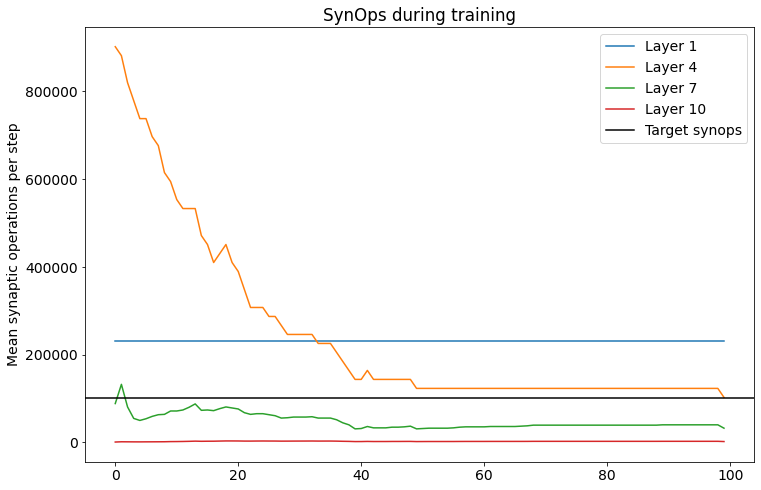

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for idx, synops in synops_per_layer.items():
    ax.plot(synops, label=f"Layer {idx}")
ax.axhline(y=target_synops, color='black', label="Target synops")
ax.set_ylabel("Mean synaptic operations per step")
ax.legend()
plt.title("SynOps during training");

We can see that the network quickly optimizes for the target number of synaptic operations. The synaptic operations for Layer 1 don't change because they depend entirely on the input and the shape of the layer, neither of which changes during training. SynOps for Layers 7 and 10 don't decrease as much because they are already below the target.

Layer 2:
	Shape: torch.Size([16, 24, 24])
	Silent neurons: 81.25%
Layer 5:
	Shape: torch.Size([32, 8, 8])
	Silent neurons: 71.88%
Layer 8:
	Shape: torch.Size([120, 1, 1])
	Silent neurons: 0.00%
Layer 11:
	Shape: torch.Size([10])
	Silent neurons: 0.00%


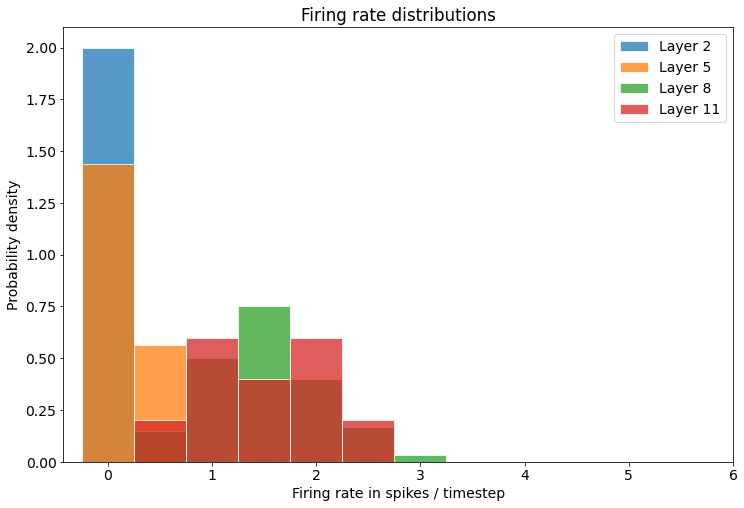

In [9]:
for layer_idx, layer in enumerate(snn):
    if isinstance(layer, sl.StatefulLayer) and hasattr(layer, "hook_data"):
        firing_rates = layer.hook_data["firing_rate_per_neuron"]
        print(f"Layer {layer_idx}:")
        print(f"\tShape: {firing_rates.shape}")
        print(f"\tSilent neurons: {(firing_rates == 0).float().mean():.2%}")
        plt.hist(
            firing_rates.detach().numpy().flat,
            bins=bins,
            label=f"Layer {layer_idx}",
            density=True,
            ec="white",
            alpha=0.75,
        )
plt.xticks(np.arange(7))
plt.xlabel("Firing rate in spikes / timestep")
plt.ylabel("Probability density")
plt.legend(loc="best")
plt.title("Firing rate distributions");

At least for layers 8 and 11 the distribution of firing rates has clearly shifted away from 0. We see that our regularizer worked. For the other two layers there is likely a conflict between reducing the SynOps and increasing the firing rate.